# Programming Project #1: Hybrid Images

## CS445: Computational Photography - Spring 2020

### Part I: Hybrid Images

In [531]:
#NOTE: ALL RESULTS ARE SAVED AS A FILE INSTEAD OF SHOWN BECAUSE MATPLOTLIB WASNT WORKING ON VSCODE MAC
import cv2

import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal

import utils

In [532]:
%matplotlib inline
import matplotlib.pyplot as plt

In [533]:
im1_file = './explosion.png'
im2_file = './explosion.png'

im1 = cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE)


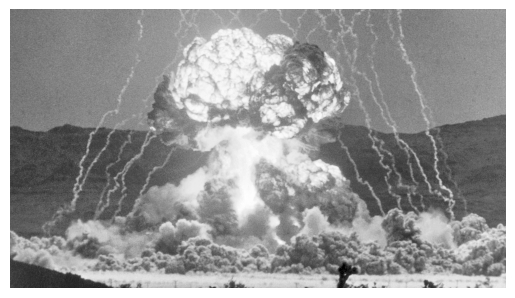

In [534]:
pts_im1 = utils.prompt_eye_selection(im1)

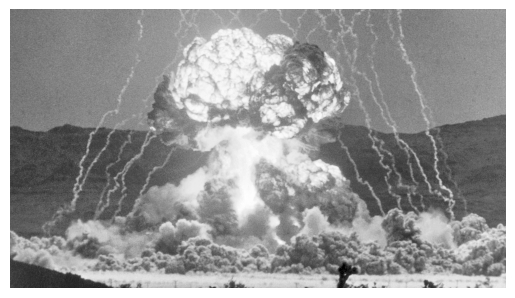

In [535]:
pts_im2 = utils.prompt_eye_selection(im2)
#pts_im2 = np.array([[1257,1251],
#                [1609,1251 ]], dtype=np.float32)
#pts_im1 = np.array([[690,440],
#                [802, 417]], dtype=np.float32)

pts_im2 = np.array([[453,287],
                [634,287]], dtype=np.float32)
pts_im1 = np.array([[453,287],
                [634,287]], dtype=np.float32)



In [536]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)

error: OpenCV(4.6.0) /Users/ec2-user/ci_py311/opencv-suite_1678377996177/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [486]:
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

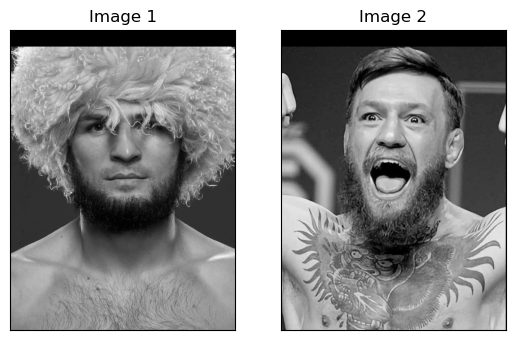

In [487]:
#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.savefig('results/test')

In [489]:

def filter_image(im, fil, fourier, lowpass=True):
    H, W =im.shape
    hs =fil.shape[0]
    fftsize =1024
    im_fft =np.fft.fft2(im,(fftsize, fftsize))
    fil_fft = np.fft.fft2(fil,(fftsize, fftsize))
    #Print Fourier Image
    fftmag = np.abs(im_fft)
    plt.imshow(fftmag,norm=LogNorm(fftmag.min(),fftmag.max()),cmap='jet')
    plt.savefig(fourier)
    #Multiply Fourier Image by Fourier Filter
    im_fil_fft=im_fft*fil_fft
    #Print Fourier Filtered
    if lowpass:
        fftmag_fil = np.abs(im_fil_fft)
        plt.imshow(fftmag_fil,norm=LogNorm(fftmag_fil.min(),fftmag_fil.max()),cmap='jet')
        plt.savefig(fourier+"_filtered")
    #return Image
    im_fil = np.fft.ifft2(im_fil_fft)
    im_fil = im_fil[hs:hs +H, hs:hs+W]
    im_fil=np.real(im_fil)
    return im_fil

def hybridImage(im1, im2, cutoff_low, cutoff_high):
    #Image 1 highpass filtering
    ksize = int(np.ceil(cutoff_high)*6+1)
    fil = cv2.getGaussianKernel(ksize, cutoff_high) # 1D kernel
    fil = fil*np.transpose(fil) # 2D kernel by outer product
    highpassed_p = filter_image(im1, fil, "results/Fourier1", False)
    im_resized = im1[ 0:highpassed_p.shape[0],0:highpassed_p.shape[1]]
    highpassed =im_resized - highpassed_p
    #Print highpassed Filtered FFT
    fftmag_fil4 = np.abs(np.fft.fftshift(np.fft.fft2(highpassed)))
    plt.imshow(fftmag_fil4,norm=LogNorm(fftmag_fil4.min(),fftmag_fil4.max()),cmap='jet')
    plt.savefig("results/Fourier1_filtered")
    
    
    #Image 2 lowpass filtering
    ksize2 = int(np.ceil(cutoff_low)*6+1)
    fil2 = cv2.getGaussianKernel(ksize2, cutoff_low) # 1D kernel
    fil2 = fil2*np.transpose(fil2) # 2D kernel by outer product
    lowpassed = filter_image(im2, fil2, "results/Fourier2")

    #resize larger image
    highpassed = highpassed[ 0:lowpassed.shape[0],0:lowpassed.shape[1]]

    #combine

    new =highpassed+lowpassed
    plt.imshow(new,cmap='gray')
    plt.savefig('results/test2')
    fftmag3 = np.abs(np.fft.fftshift(np.fft.fft2(new)))
    plt.imshow(fftmag3,norm=LogNorm(fftmag3.min(),fftmag3.max()),cmap='jet')
    plt.savefig('results/Fourier_combined')
    
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        cutoff_low: standard deviation for the low-pass filter
        cutoff_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''    


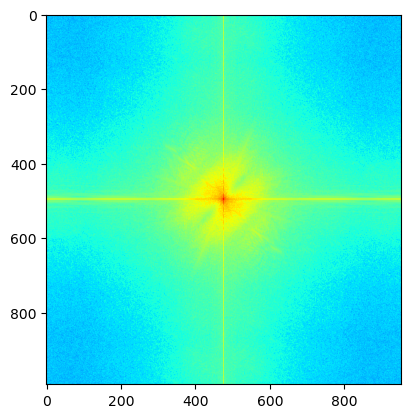

In [498]:
cutoff_low = 5
cutoff_high = 2

im_hybrid = hybridImage(im2, im1, cutoff_low, cutoff_high)

In [398]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
#cropped_object = utils.interactive_crop(im_hybrid)

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

In [408]:
def enhance_contrast(image_base, gray_scale=True):
    image = cv2.imread(image_base)
    if gray_scale:
        im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_eq = cv2.equalizeHist(im)
        cmap_val = 'gray'
    else:
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        r_image, g_image, b_image = cv2.split(im)

        r_image_eq = cv2.equalizeHist(r_image)
        g_image_eq = cv2.equalizeHist(g_image)
        b_image_eq = cv2.equalizeHist(b_image)

        image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
        cmap_val = None
    
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.axis("off")
    ax1.title.set_text('Original')
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.axis("off")
    ax2.title.set_text("Equalized")
    ax1.imshow(im, cmap=cmap_val)
    ax2.imshow(image_eq, cmap=cmap_val)
    plt.savefig('results/contrast1')
    return image_eq

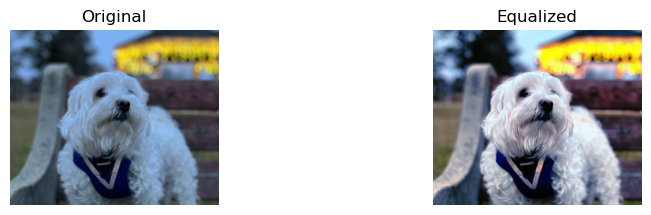

In [409]:
contrast_file = './Jaxpart.png'
image_eq = enhance_contrast(contrast_file, False)


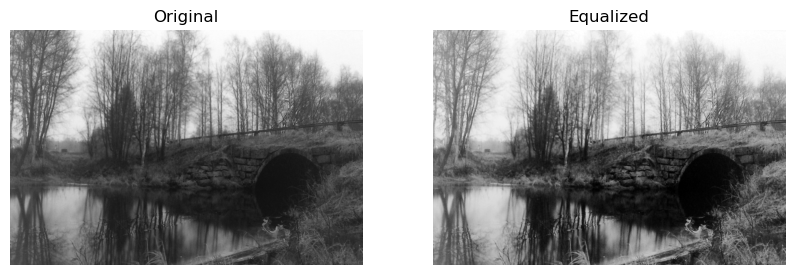

In [295]:

contrast_file2 = './woods.png'
image_eq = enhance_contrast(contrast_file2, True)


#### Color enhancement 

In [406]:
def enhance_color(image_base, factor):
    image = cv2.imread(image_base)
    im_HSV = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

    im_b = im_HSV[:,:,1] 
    mask = im_b*factor <= 255 
    im_b[mask] = im_b[mask]*factor

    im_HSV= cv2.cvtColor(im_HSV,cv2.COLOR_HSV2BGR)

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.axis("off")
    ax1.title.set_text('Original')
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.axis("off")
    ax2.title.set_text("Color Enhanced")
    ax1.imshow(image, cmap=None)
    ax2.imshow(im_HSV, cmap=None)
    plt.savefig('results/color1')
    return im_HSV


#### Color shift

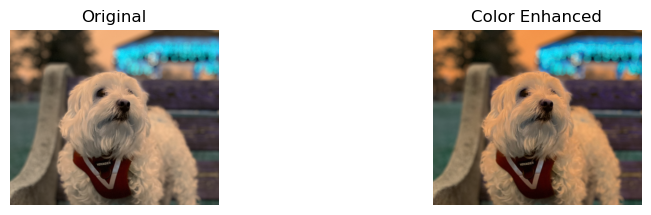

In [407]:
enhanced = enhance_color("./Jaxpart.png", 1.4)